In [37]:
import os
import numpy as np

def load_feat_stat():
    temp_file = 'feat_stat.npy'
    moments = np.load(temp_file)
    moments = moments.item()
    m = [moments[field][0] for field in header]
    m2 = [moments[field][1] for field in header]
    var = m2# - m**2
    dev = np.sqrt(var)
    return dev
dev = load_feat_stat()

In [56]:
def load_header(model_path):
    header_file = os.path.join(model_path, 'selected_header.txt')
    with open(header_file, 'r') as f:
        header = f.readlines()
    header = [h.rstrip() for h in header]
    return header
#model_path = r'models\bingsat_reg_adam_batch_topfeat'
#model_path = r'models\bingsat_reg_adam_batch_log_bucket_topfeat'
model_path = r'models\bingsat_rank_dense'
header = load_header(model_path)

In [57]:
import tensorflow as tf
def load_ckpt(model_path):
    ckpt = tf.train.latest_checkpoint(model_path)
    """
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    sess = tf.Session(config = config)
    saver = tf.train.import_meta_graph(ckpt + '.meta')
    saver.restore(sess, ckpt)
    """
    """from tensorflow.python.tools.inspect_checkpoint import print_tensors_in_checkpoint_file
    all_vars = tf.get_collection(tf.ops.GraphKeys.GLOBAL_VARIABLES)
    """
    reader = tf.train.NewCheckpointReader(ckpt)
    variables = reader.get_variable_to_shape_map()
    return reader, variables
reader, vairables = load_ckpt(model_path)

In [60]:
print (np.reshape(w, (-1,1)).shape)

(6903, 1)


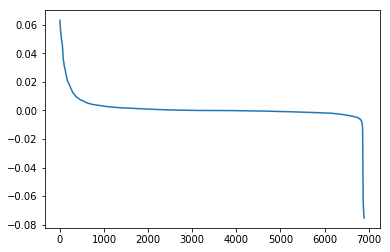

In [61]:
#import operator
%matplotlib inline
ws = reader.get_tensor('net/layer_2/kernel')
ws = np.squeeze(ws)
if len(ws.shape) == 1:
    ws = np.reshape(ws, (-1, 1))
for c in range(ws.shape[-1]):
    w = ws[:, c]
    d = {header[i]:w[i] for i in range(len(w))}
    #s = sorted(d.items(), key=operator.itemgetter(1))
    s = sorted(d.items(), key=lambda kv: kv[1], reverse=True)
    #for k,v in s:
    #    print (k, v)
    from matplotlib import pyplot as plt

    v = [v for k,v in s]
    plt.plot(v)
    with open ('weights_top_rank{}.txt'.format(c), 'w') as f:
        f.writelines(['{}\t{}\n'.format(k, v) for k,v in s])

In [64]:
# dump top features
def dump_by_threshold(files, ofile, th):
    top_feat = set()
    for file in files:
        with open(file, 'r') as f:
            for line in f:
                feat, weight = line.rstrip().split()
                if abs(float(weight)) > th:
                    top_feat.add(feat)
    top_feat = sorted(top_feat)
    with open(ofile, 'w') as f:
        for feat in top_feat:
            f.write(feat+'\n')
    return top_feat
top_feat = dump_by_threshold(['weights_top_rank{}.txt'.format(c) for c in range(ws.shape[-1])], 'top_feature_list_rank.txt', 0.01)
print (len(top_feat))
"""
top_feat = set()
for file in ['weights.txt', 'weights_2.txt']:
    with open(file, 'r') as f:
        for i in range(300):
            line = f.readline()
            top_feat.add(line.split()[0])
with open('top_feature_list.txt', 'w') as f:
    for feat in sorted(top_feat):
        f.write(feat+'\n')
"""

399


"\ntop_feat = set()\nfor file in ['weights.txt', 'weights_2.txt']:\n    with open(file, 'r') as f:\n        for i in range(300):\n            line = f.readline()\n            top_feat.add(line.split()[0])\nwith open('top_feature_list.txt', 'w') as f:\n    for feat in sorted(top_feat):\n        f.write(feat+'\n')\n"

In [65]:
def load_header(model_path):
    header_file = os.path.join(model_path, 'selected_header.txt')
    with open(header_file, 'r') as f:
        header = f.readlines()
    return [h.rstrip() for h in header]
def load_dev(header):
    temp_file = 'feat_stat.npy'
    moments = np.load(temp_file)
    moments = moments.item()
    m = [moments[field][0] for field in header]
    m2 = [moments[field][1] for field in header]
    var = m2# - m**2
    return np.sqrt(var)
def weights2freeform(weights_file, model_path, ff_file):
    # load weights
    weights = {}
    with open(weights_file, 'r') as f:
        for line in f:
            tokens = line.rstrip().split()
            weights[tokens[0]] = float(tokens[1])
            #if len(weights) > 32:
            #    break
    header = load_header(model_path)
    dev = load_dev(header)

    ff = ''
    for i, h in enumerate(header):
        if h not in weights:
            continue
        coef = weights[h] / dev[i]
        mul = '(* {} {})'.format(coef, h)
        if len(ff) == 0:
            ff = mul
        else:
            ff = '(+ {} {})'.format(mul, ff)
    with open(ff_file, 'w') as f:
        f.write(ff+'\n')
#weights2freeform('weights_top_4.txt', r'models\bingsat_reg_adam_batch_topfeat', 'freeform_32.txt')
weights2freeform('weights_top_rank0.txt', r'models\bingsat_rank_dense', 'freeform_rank_dense.txt')
#for i in range(4):
#    weights2freeform(f'weights_top_c{i}.txt', r'models\bingsat_reg_adam_batch_log_bucket_topfeat', f'freeform_c{i}.txt')